In [1]:
import tensorflow as tf
print(tf.__version__)
import os
import numpy as np

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

2.8.0


In [2]:
# Random seed
np.random.seed = 42

# Input image dimensions
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

Notes to self:
- Play with the padding, the kernel initializer and the normalization of images

In [3]:
# Set the layers
## input
input = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
normalized_input = tf.keras.layers.Lambda(lambda x: x / 255)(input) # Change this by dividing after import maybe?

## Contraction
### C1 => 128x128x16
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(normalized_input)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)

### C2 => 64x64x32
p1 = tf.keras.layers.MaxPool2D((2, 2), strides=2)(c1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)

### C3 => 32x32x64
p2 = tf.keras.layers.MaxPool2D((2, 2), strides=2)(c2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

### C4 => 16x16x128
p3 = tf.keras.layers.MaxPool2D((2, 2), strides=2)(c3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

### C5 => 8x8x256
p4 = tf.keras.layers.MaxPool2D((2, 2), strides=2)(c4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

2022-08-19 15:16:37.806724: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
## Expansion
### U6 => U6 + C4 (16x16x256)
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=2, padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
### C6 => 16x16x128
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

### U7 => U7 + C3 (32x32x128)
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=2, padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
### C7 => 32x32x64
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

### U8 => U8 + C2 (64x64x64)
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=2, padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
### C8 => 64x64x32
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

### U9 => U9 + C1 (128x128x32)
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=2, padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
### C9 => 128x128x16
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

In [5]:
## output
output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [6]:
# set the model
model = tf.keras.Model(inputs=[input], outputs=[output])
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

## Dataset

In [7]:
dataset_path = '../dataset/stage1_train'
ids = os.listdir(dataset_path)

In [8]:
X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [9]:
for n, id in tqdm(enumerate(ids), total=len(ids)):
  path = f"{dataset_path}/{id}"
  img = cv2.imread(f"{path}/images/{id}.png")

  img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  X[n] = img
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

  for mask_file in os.listdir(path + "/masks/"):
    mask_ = cv2.imread(path + "/masks/" + mask_file, cv2.IMREAD_GRAYSCALE)
    mask_ = np.expand_dims(
      cv2.resize(mask_, (IMG_HEIGHT, IMG_WIDTH)),
      axis=-1
      )
    mask = np.maximum(mask, mask_)
  y[n] = mask

100%|██████████| 670/670 [01:00<00:00, 11.04it/s]


In [10]:
# Split data into train and test
random_elements = np.random.choice(len(X), int(len(X) * 0.8), replace=False)

mask = np.zeros(len(X), dtype=bool)
mask[random_elements] = 1

X_train = X[mask]
X_test = X[~mask]
y_train = y[mask]
y_test = y[~mask]


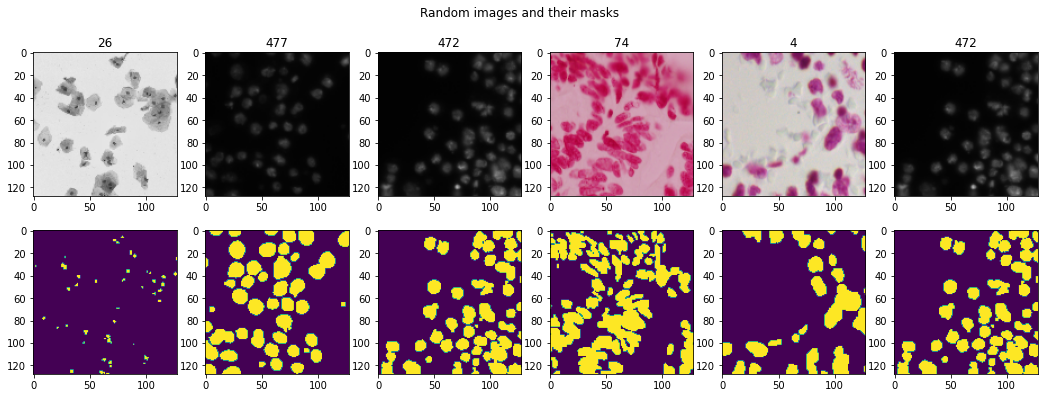

In [11]:
nb_images = 6
fig, (top, bottom) = plt.subplots(2, nb_images, figsize=(3 * nb_images, 6))
random_ids = np.random.rand(nb_images) * len(X)

fig.suptitle("Random images and their masks")

for i, (ax_t, ax_b) in enumerate(zip(top, bottom)):
  id = int(random_ids[i])
  ax_t.set_title(id)
  ax_t.imshow(X[id])
  ax_b.imshow(y[id])


## Callbacks

In [12]:
# EarlyStopping, ModelCheckpoint and Tensorboard
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_nuclei.h5', verbose=1, save_best_only=True) #save_weight_only ?
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [36]:
model.load_weights('./unet_nuclei.h5')
raise Exception("loaded previous model")

Exception: loaded previous model

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=25, callbacks=[model_checkpoint, early_stopping, tensorboard])

Epoch 1/25
16/16 [==============================] - ETA: 0s - loss: 0.6265 - accuracy: 0.8400
Epoch 1: val_loss improved from inf to 0.54572, saving model to unet_nuclei.h5
16/16 [==============================] - 32s 2s/step - loss: 0.6265 - accuracy: 0.8400 - val_loss: 0.5457 - val_accuracy: 0.8651
Epoch 2/25
16/16 [==============================] - ETA: 0s - loss: 0.4540 - accuracy: 0.8427
Epoch 2: val_loss improved from 0.54572 to 0.31587, saving model to unet_nuclei.h5
16/16 [==============================] - 30s 2s/step - loss: 0.4540 - accuracy: 0.8427 - val_loss: 0.3159 - val_accuracy: 0.8659
Epoch 3/25
16/16 [==============================] - ETA: 0s - loss: 0.2975 - accuracy: 0.8496
Epoch 3: val_loss did not improve from 0.31587
16/16 [==============================] - 32s 2s/step - loss: 0.2975 - accuracy: 0.8496 - val_loss: 0.3213 - val_accuracy: 0.9090
Epoch 4/25
16/16 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.8749
Epoch 4: val_loss improved f

## Make predictions, display a sample and evaluate

In [17]:
y_pred = model.predict(X_test)
filtered_preds = (y_pred > 0.5).astype(np.uint8)

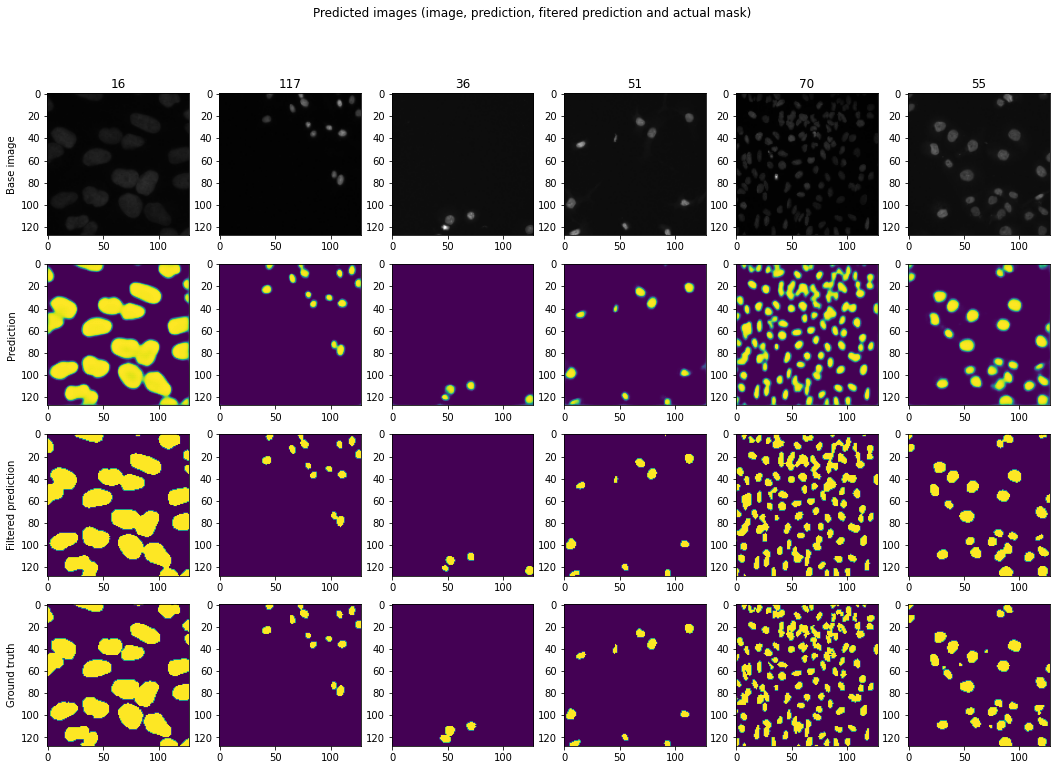

In [40]:
nb_images = 6
fig, ax = plt.subplots(4, nb_images, figsize=(3 * nb_images, 12))
random_ids = np.random.rand(nb_images) * len(y_pred)

fig.suptitle("Predicted images (image, prediction, fitered prediction and actual mask)")

for i, (ax_x, ax_pred, ax_pred_filtered, ax_val) in enumerate(zip(*ax)):
  id = int(random_ids[i])
  ax_x.set_title(id)

  ax_x.imshow(X_test[id])
  ax_pred.imshow(y_pred[id])
  ax_pred_filtered.imshow(filtered_preds[id])
  ax_val.imshow(y_test[id])

  if not i:
    ax_x.set_ylabel("Base image")
    ax_pred.set_ylabel("Prediction")
    ax_pred_filtered.set_ylabel("Filtered prediction")
    ax_val.set_ylabel("Ground truth")

In [27]:
intersection = np.logical_and(filtered_preds, y_test)
union = np.logical_or(filtered_preds, y_test)
iou_score = np.sum(intersection) / np.sum(union)
print('IoU is %.2f' % (iou_score * 100))

IoU is 81.57


In [28]:
dice_score = np.sum(intersection) / (np.sum(filtered_preds) + np.sum(y_test))
print('Dice Score is %.2f' % (dice_score * 100))

Dice Score is 44.93
